In [1]:
from bs4 import BeautifulSoup #for parsing html pages 
import json, requests, urllib #for handling the urls and json files
from pathlib import Path #
import pandas as pd #later on for dealing with datasets
import matplotlib.pyplot as plt
import numpy as np

#this is all the machine learning stuff
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, RepeatedKFold

#the various classifiers 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB

#the evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

# Web Scraping and Data Extraction 

The first step of the task will be to scrape a series of web pages to extract details corresponding to a series of news arcticles. The web pages have a central index page which separates the news stories by month. Within each month exists $\sim1000$ articles broken up into categories: 

- UK News
- US News
- Sport
- Film 
- Books
- Life & Style
- Business
- Politics


To perform this task we will utilise the BeautifulSoup module which allows us to parse html code and extract specific data, depending on our requirements.  

The first step in scraping the web pages is establishing the structure of the URLs from which we will be scraping the data. 

In [2]:
#define the base url which we will append information to parse the web pages
base_url = 'http://mlg.ucd.ie/modules/COMP41680/assignment2/'

#the first page of each month ends the same way 
first_page = '-001.html'

#the months need to be hard coded in
months = ['jan',
         'feb',
         'mar',
         'apr',
         'may',
         'jun',
         'jul',
         'aug',
         'sep',
         'oct',
         'nov',
         'dec']
#quick test to see if it formats correctly 
for i in months[0:4]: 
    print(base_url+'month-'+i+first_page)

http://mlg.ucd.ie/modules/COMP41680/assignment2/month-jan-001.html
http://mlg.ucd.ie/modules/COMP41680/assignment2/month-feb-001.html
http://mlg.ucd.ie/modules/COMP41680/assignment2/month-mar-001.html
http://mlg.ucd.ie/modules/COMP41680/assignment2/month-apr-001.html


The above URLs are the "gateway" into the articles for each month. These pages contain an important feature which is the number of pages in each month. We need to know this number so we can define how many pages we need to parse for each month. For example January has 31 pages of articles whereas February has 30, March has 28 etc.  

The next step is to request the url, decode it to raw html and then use BeautifulSoup to convert the raw code into a parsable soup object. From this we can extract the number of pages per month

In [3]:
def make_soup(url):     
    """Takes an input url and converts it to a soup object"""    
    response = urllib.request.urlopen(url)
    raw_html= response.read().decode()
    return BeautifulSoup(raw_html, "html.parser")

def get_page_number(html_soup):    
    """Parses a BeautifulSoup html object to extract the number 
       of pages of news stories"""    
    page_num = html_soup.find_all('h4',{"class":"results"})
    number = page_num[0].text.strip()    
    split_result = number.split(' ')
    total_pages = split_result[-1]
    return int(total_pages)

def page_list(html_soup):     
    """Gets the page numbers needed to cycle through each month as a 
       list of strings which can be appended to a url at a later date."""    
    page_number = get_page_number(html_soup)
    one_char = ['00'+str(i) for i in range(page_number+1)[1:] if len(str(i)) <= 1]
    two_char = ['0'+str(i) for i in range(page_number+1)[1:] if len(str(i)) > 1]
    return one_char+two_char

We now know how many pages of articles are contained in each month so the next step is to consider how we will extract the news data and in what format will it be stored. 

The method of storage used in this project will be a JSON file. The news articles will be each saved as a dictionary with the keys "Title", "Category" and "Snippet" and appended to a list of extracted articles. This will make for easy conversion to JSON objects. 

The data will require a small amount of formatting before being saved which is performed by the functions in the cell below

In [4]:
def format_metadata(entry):     
    """Extracts the category for each news article
       every second line of metadata so % 2 =/= 0"""
    return [entry[i].text.replace('Category: ', '') for i in range(len(entry)) if i % 2 != 0]

def format_headlines(entry):
    """Format headlines for extraction """
    return [(entry[i].text.split('\xa0'))[1] for i in range(len(entry))]

def format_snippets(entry):
    """Format snippets for extraction"""
    return [(entry[i].text.strip('Summary:')) for i in range(len(entry))]


def extract_data(soup):
    
    """Extracts the news data from a single html page 
       and saves each entry as a dictionary. Output is 
       a list of dictionaries."""
    
    headlines = soup.find_all('h5')
    metadata = soup.find_all('p',{"class":"metadata"})
    snippets = soup.find_all('p',{"class":"snippet"})
    all_news = [] #set up ep
    
    clean_headlines = format_headlines(headlines)
    categories = format_metadata(metadata)
    clean_snippets=format_snippets(snippets)

    for i in range(len(headlines)):
        #save article as a dictionary
        news_dict = {}
        news_dict['Headline'] = clean_headlines[i]
        news_dict['Category'] = categories[i]    
        news_dict['Snippet'] = clean_snippets[i]
        #append dictionary as a list
        all_news.append(news_dict)
    return all_news     

The function $\texttt{extract_data}$ takes a single html page and extracts the requisite data. Therefore to collect the news articles from an entire month we need to iterate this function over all the pages and save the result to a single list. 

This is done with the $\texttt{collect_month}$ function which cycles through all the pages in a month.

In [5]:
def collect_month(month):
    
    """Extracts all the news entries for a given month into a list of 
       dictionaries."""
    
    page_num_url = base_url+'month-'+month+first_page
    pgn_soup = make_soup(page_num_url)
    pages = page_list(pgn_soup)
    total_month = []
    for page in pages: 
        data_url = base_url+'month-'+month+'-'+page+'.html'
        page_entries = make_soup(data_url)
        collected_entries = extract_data(page_entries)
        total_month.extend(collected_entries)   
    return total_month

Finally for the whole year we just cycle through all the months, using $\texttt{collect_month}$ for each specific month.

In [6]:
def collect_year(): 
    
    """Loops through a list of months to extract news articles
    for each month. """
    
    total_year = []
    for month in months:
        total_year.extend(collect_month(month))
    return total_year

whole_year = collect_year()

We have our data! The following cell shows the whole data set as a large list of dictionaries labeled as the variable $\texttt{whole_year}$. 

In [7]:
whole_year

[{'Headline': "Let's resolve to reconnect, says Welby in new year message",
  'Category': 'UK-News',
  'Snippet': 'The archbishop of Canterbury will urge people to make personal connections with others in 2020 to create a new unity in a divided society. In his new …'},
 {'Headline': "Be honest. You're not going to read all those books on your holiday, are you?",
  'Category': 'Books',
  'Snippet': 'Every year, about this time, my Instagram feed fills up with pictures of books. They’re piled somewhere between five and ten inches high, sometimes st …'},
 {'Headline': "Mariah Carey's Twitter account hacked on New Year's Eve",
  'Category': 'Music',
  'Snippet': 'Mariah Carey’s Twitter account appeared to have been hacked late Tuesday afternoon, sharing numerous racist slurs and comments with the singer’s 21.4 …'},
 {'Headline': 'The joy audit: how to have more fun in 2020',
  'Category': 'Life-and-Style',
  'Snippet': 'The last time I felt joy was at an event that would be many people’s v

We now have a big list of all the news articles over all the months but we only want three categories out of all the stories. 

We will choose "Film", "US-News", and "UK News" for our three categories.

In [8]:
def category_filter(data_list, category):
    """Filters a """
    return [i for i in data_list if i['Category'] == category]

    
film_entries = category_filter(whole_year, 'Film')
uknews_entries = category_filter(whole_year, 'UK-News')
usnews_entries = category_filter(whole_year, 'US-News')

total_selected = film_entries + uknews_entries + usnews_entries

With our selection of news stories filtered by our three categories we can save them to a JSON file so that they can be used later on.

**Note:** The JSON file contains ONLY the three selected categories. The rest of the articles are not saved.

In [9]:
with open('2020_news.json', 'w') as fout:
    json.dump(total_selected , fout)         

# Binary Classification 

We have 3 categories so the first thing we will do is test a binary classification model and its ability to distinguish and identify between a pair of categories. 

We have 3 categories chosen so we will test the binary classification on the different dual combination of categories i.e. if we have A = Film, B = UK News, and C = US News we will test the classification ability for AB, BC, and AC. 

In [10]:
from nltk.stem import WordNetLemmatizer

In [11]:
#lets load up the data we just saved
with open(r"2020_news.json", "r") as read_file:
    newsdata = json.load(read_file)
    
newsdata = pd.DataFrame(newsdata)
#newsdata = newsdata.sample(frac=1).reset_index(drop=True)

values = []
for i in range(len(newsdata['Category'])):  
    
    if newsdata['Category'][i]=='UK-News': 
        values.append('0')
    elif newsdata['Category'][i]=='Film': 
        values.append('1')
    elif newsdata['Category'][i]=='US-News': 
        values.append('2')
        
newsdata['Values'] = values     
#newsdata = newsdata.loc[newsdata['Values'] == 1]
newsdata

,Headline,Category,Snippet,Values
0,"War epics, airmen and young Sopranos: essentia...",Film,1917 An epic of Lean-ian proportions is delive...,1
1,The most exciting movies of 2020 – horror,Film,The Grudge A belated English language reboot o...,1
2,In the Line of Duty review – race-against-time...,Film,There’s a straight-to-video feel to this cop t...,1
3,We Are from Jazz review – zany Russian musical...,Film,Only in a Woody Allen film will you hear quite...,1
4,First transgender Marvel superhero coming 'ver...,Film,The first transgender character in a Marvel mo...,1
...,...,...,...,...
5376,From Sarah Cooper to Fiona Hill: the ‘stars’ o...,US-News,Millions of lives across America and the world...,2
5377,What happened when California tried to fix its...,US-News,"Before the coronavirus even reached the US, Ca...",2
5378,First Thing: McConnell thwarts hopes of higher...,US-News,"Good morning. Donald Trump’s calls for $2,000 ...",2
5379,Joe Biden to have new Secret Service team amid...,US-News,Joe Biden is expected to receive Secret Servi...,2


## Different Pairs of Categories:
### 1. UK-News vs US-News

I am particularly interested to see if there are any major differences between the categories of UK vs US news stories and whether there will be any issues in characterisation. One would expect differences between the two countries i.e. a lot more presidential news in the US, news pertaining to Trump/Biden whereas we might see more "Brexit" and "Boris" articles in the UK News.

In [12]:
def document_dataframe(dataframe): 
    """Takes JSON data and creates a pandas dataframe containing the data"""
    new_df = pd.DataFrame()
    new_df['Document'] = [(dataframe['Headline'][i]+' '+dataframe['Snippet'][i]).lower() 
                          for i in range(len(dataframe['Headline']))]
    new_df['Category'] = dataframe['Category']
    return new_df


#df is the full dataframe of all three categories
#for the binary classification we will extract sub-dataframes
#containing whatever two categories we need from this main one

df = document_dataframe(newsdata)
uk_vs_us = df.drop(df[df['Category']=='Film'].index)
uk_vs_us

,Document,Category
1771,"let's resolve to reconnect, says welby in new ...",UK-News
1772,visa applications: home office refuses to reve...,UK-News
1773,victims of nye surrey road crash were ba cabin...,UK-News
1774,man held on suspicion of double murder after b...,UK-News
1775,anti-islamic slogans spray-painted near mosque...,UK-News
...,...,...
5376,from sarah cooper to fiona hill: the ‘stars’ o...,US-News
5377,what happened when california tried to fix its...,US-News
5378,first thing: mcconnell thwarts hopes of higher...,US-News
5379,joe biden to have new secret service team amid...,US-News


In [13]:
#set up our documents and our targets
target_categories = ["UK-News", "US-News"]
documents = uk_vs_us["Document"]
target = uk_vs_us["Category"]

#lets see how many articles we have of both categories
print("Number of UK News Articles: %s" %target.value_counts()['UK-News'])
print("Number of US News Articles: %s" %target.value_counts()['US-News'])

Number of UK News Articles: 1795
Number of US News Articles: 1815


The next step is to transform the list of documents and associated categories into Document Term Matrix. This is performed using  the $\texttt{TfidfVectorizer}$ which breaks the text of each document down into a document term matrix that is weighted according to the following expression:

$$w(t,D)=tf(t,d) \times (\log(\frac{n}{df(t)})+1)$$

The aim of this weighting term is to lessen the weight of terms that appear throughout a lot of the documents.

In [14]:
vectorizer = TfidfVectorizer(min_df = 10, stop_words='english', ngram_range=(1,2))
X = vectorizer.fit_transform(documents)
terms = vectorizer.get_feature_names()
print(r"Document Term Matrix has dimensions %d x %d" %X.shape)
print("Vocabulary has %d distinct terms" %X.shape[1] )
print("Example tokens: ", terms[450:470])

Document Term Matrix has dimensions 3610 x 1591
Vocabulary has 1591 distinct terms
Example tokens:  ['donald', 'donald trump', 'double', 'downing', 'downing street', 'dozens', 'dr', 'dramatic', 'driver', 'drivers', 'driving', 'drop', 'dropped', 'drug', 'drugs', 'duchess', 'duchess sussex', 'duke', 'duke duchess', 'dunn']


We can already see the benefits of having pairs of words together. Tokens such as "Dowing Street" and "Donald Trump" being included in the dataset will definitely assist in the classification of UK and US news stories. 

Lets have a look at the terms that carry the most weight from the TF-IDF weighted DTM.

In [15]:
# sum over the columns
freqs = X.sum(axis=0)
# sort the indexes of the array by value, and then reverse it
sorted_term_indexes = freqs.argsort()
sorted_term_indexes = sorted_term_indexes[0, ::-1]
for i in range(20):
    term_index = sorted_term_indexes[0,i]
    print("%d. %s = %.2f" % ((i+1), terms[term_index], freqs[0,term_index] ))

1. trump = 142.15
2. police = 79.95
3. coronavirus = 73.65
4. donald = 73.53
5. donald trump = 71.55
6. new = 61.54
7. uk = 60.93
8. biden = 60.19
9. covid = 57.22
10. people = 47.25
11. election = 45.54
12. man = 44.65
13. year = 43.41
14. joe = 42.57
15. 19 = 42.25
16. joe biden = 39.98
17. covid 19 = 39.87
18. home = 37.10
19. government = 35.38
20. lockdown = 33.88


Trump takes the top spot. This is to be expected given that the news articles are taken from 2020 and we are currently focusing on US news stories so a large amount of them are presumably focused on the US Presidential race. This would explain the "Biden" and "Joe Biden" entries further down the list. 

We need to split our data into a training set and a test set. Here we will use 70% of the data to train our model and the reamining 30% will be used to test it. This may sound like a small fraction but given that the total number of US and UK News stories is 3610 we will be testing a sample size of 1083 articles. 

In [16]:
#split the data into test vs training and see how many articles fall into each group 
data_train, data_test, target_train, target_test = train_test_split(X, target, test_size=0.3)
print("Training set has %d examples" % data_train.shape[0] )
print("Test set has %d examples" % data_test.shape[0] )

#create the model using a K-neighbours classifier and train it using the training data
model = KNeighborsClassifier(n_neighbors=3)
model.fit(data_train, target_train)

#run a quick prediction and see how it holds up with an accuracy score
predicted = model.predict(data_test)
print("Accuracy = %.4f" % accuracy_score(target_test, predicted))

Training set has 2527 examples
Test set has 1083 examples
Accuracy = 0.8772


The model does quite a good job of identifying the two categories but there is still about 10-15% that are being incorrectly classified. These are the interesting articles because they clearly contain language or terms that either feature a strong overlap in terms or due to context/subject matter are being misinterpreted. The following cell shows an example of 3 stories that despite being UK News have been classified by the model as US News stories so lets see if there are any obvious reasons for the wrong classification.

In [17]:
# examples of UK News Articles being predicted as US News
num_examples = 0 
for i, predicted_class in enumerate(predicted):
    if target_test.iloc[i] == 'UK-News' and predicted_class == 'US-News':
        news_art = target_test.index[i]
        print( "%s: %s" % (news_art, df.loc[news_art]["Document"]))
        num_examples += 1
    if num_examples == 5:
        break

1876: caledonian sleeper boss to quit much-criticised service the boss of the caledonian sleeper train has resigned a day after the scottish transport secretary said faults with the embattled rail service would t …
3563: 'happy vaccine day' at welsh factory proudly preparing oxford doses  most of the sprawling industrial estate on the edge of wrexham was quiet. there was little sign of activity at the engineering firms or in the self-st …
2249: grime artist solo 45 found guilty of raping four women the grime artist andy anokye, who performs as solo 45, has been found guilty of subjecting four women to a horrifying campaign of rape. anokye’s victi …
3288: michael booth obituary my stepfather, michael booth, who has died aged 87, was called up for national service in the royal navy in 1952 and enjoyed it so much that he took o …
3376: unions call for frontline uk workers to be prioritised for covid vaccine  unions have called for key frontline workers to be granted priority access to an 

And vice versa...why are US News articles being mistaken for UK News?

In [18]:
# examples of US News articles being predicted as UK News

num_examples = 0 
for i, predicted_class in enumerate(predicted):
    if target_test.iloc[i] == 'US-News' and predicted_class == 'UK-News':
        news_art = target_test.index[i]
        print( "%s: %s" % ( news_art, df.loc[news_art]["Document"] ) )
        num_examples += 1
    if num_examples == 5:
        break

4427: why the covid-19 financial crisis will leave lasting scars on gen z graduation was supposed to be one of the best moments of stephany torres’s life. as a first-generation student at the university of california los ang …
4526: 'nobody’s ever seen anything like this': how coronavirus turned the us election upside down mar-a-lago was the place to see and be seen for guests who paid thousands of dollars for the privilege on new year’s eve. diamonds and furs abounded o …
4998: trump administration alters and downplays human rights abuses in reports the trump administration has omitted or altered vital information about human rights – including torture, reproductive rights and persecution based on …
4512: us ambassador to uk accused of making racist and sexist remarks  the us ambassador to the uk, woody johnson, was reportedly investigated by a state department watchdog over alleged racist and sexist comments to staf …
4484: pompeo claims private property and religious freedom are 'fo

To get a general overview of the performance of the model and to see if there are any particular areas in which incorrect classifications are occuring more often we can display the predicted vs actual categories as a confusion matrix. Ideally we will see the diagonal elements of the matrix being full of correct predictions with the non-diagonal elements being zero or close to zero. 

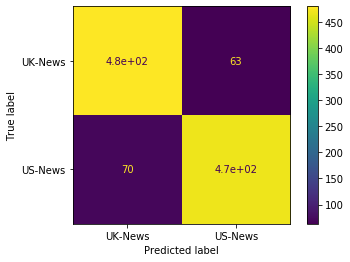

In [19]:
# calculate the matrix 
cm = confusion_matrix(target_test, predicted, labels=['UK-News','US-News'])
# display it graphically
cmd = ConfusionMatrixDisplay(cm, display_labels=target_categories)
cmd.plot()

So we can see here that the K-neighbour technique works reasonably well with the majority of the tested documents being correctly identified as their respective categories. 

A different evaluation metric is the precision 

In [20]:
print("Precision (UK News) = %.4f" % precision_score(target_test, predicted, pos_label='UK-News') )
print("Recall (UK News) = %.4f" % recall_score(target_test, predicted, pos_label='UK-News') )

Precision (UK News) = 0.8727
Recall (UK News) = 0.8840


Having run the model a number of times I noticed a slight variation each time. This is due to the $\texttt{train_test_split}$ model pulling a different 70% of the articles each time leading to a small differences in accuracy each time. 

To gain a brief insight into how the values vary we will run 50 tests and then get the mean accuracy score as well as its $\sigma$ and $3\sigma$ uncertainty.

In [21]:
acc_scores=[]
for i in range(50): 
    data_train, data_test, target_train, target_test = train_test_split(X, target, test_size=0.3)
    model = KNeighborsClassifier(n_neighbors=3)
    model.fit(data_train, target_train)    
    predicted = model.predict(data_test)
    acc_scores.append(accuracy_score(target_test, predicted))
    
print("Mean accuracy = %.4f" %np.mean(acc_scores))
print("σ of accuracy scores = %.4f" %np.std(acc_scores))
print("3σ of accuracy scores = %.4f" %(3*np.std(acc_scores)))

Mean accuracy = 0.8719
σ of accuracy scores = 0.0083
3σ of accuracy scores = 0.0250


###  UK-News vs US-News: Cross Fold Technique

Rather than simply splitting the data randomly into test and training sets we can employ the cross fold technique. We split the data into $k$ subsets (called folds). We then run $k$ experiments which using $k-1$ sets to train the model and the remaining set is used to test the data.

At the end of the experiments we will take the mean of the accuracy as our final value.

In [22]:
#NOTE: This cell takes a long time to run so don't do it unless you need to!!!!

params = [2,3,4,5,6,7,8,9]
folds ={}

for i in params:
    rkf = RepeatedKFold(n_splits=i, n_repeats=10)
    acc_scores = cross_val_score(model, X, target, cv=rkf, scoring="accuracy")
    # represent the results as a Pandas Series
    labels = ["Fold %d" % i for i in range(1,len(acc_scores)+1)]
    s_acc = pd.Series(acc_scores, index = labels)
    folds[i]=s_acc.mean()
    

folds_data = pd.DataFrame.from_dict(folds,columns=['Mean Accuracy'],orient='index')
folds_data

,Mean Accuracy
2,0.871302
3,0.869695
4,0.874600
5,0.872548
6,0.874708
7,0.875486
8,0.873879
9,0.876010


## Using a pipeline

$\texttt{sklearn}$ has a pipeline function that allows for the easy processing and classification of bodies of text. We have demonstrated above have the process works so for the remaining two pairs we will establish a pipeline that will allow for quick construction of a classification model.  

Here we will use two methods:
- The standard random split performed using $\texttt{train_test_split}$
- The k-fold method

In [23]:
from sklearn.pipeline import Pipeline #import pipeline from sklearn

In [24]:
knc_pipeline = Pipeline([
    ('vec', TfidfVectorizer(min_df = 10, stop_words='english',ngram_range=(1,2))),
    ('clf', KNeighborsClassifier(n_neighbors=3))
])

### 2. UK News vs Film 

We have seen the classifier work on UK vs US news stories. So now the K-Neighbours classifier will be used to discern between UK News and Film articles. 

The general set up is the same as the process we used in the UK vs US news section but we will use the pipeline to speed everything up slightly.

In [25]:
#get rid of US News from our list 
uk_vs_film = df.drop(df[df['Category']=='US-News'].index)
uk_vs_film

,Document,Category
0,"war epics, airmen and young sopranos: essentia...",Film
1,the most exciting movies of 2020 – horror the ...,Film
2,in the line of duty review – race-against-time...,Film
3,we are from jazz review – zany russian musical...,Film
4,first transgender marvel superhero coming 'ver...,Film
...,...,...
3561,how edward heath taking a bath exposed chequer...,UK-News
3562,uk weather: snow and ice to bring 2020 to wint...,UK-News
3563,'happy vaccine day' at welsh factory proudly p...,UK-News
3564,tier 4 covid rules in england: latest restrict...,UK-News


We set up our categories as we did previously. 

In [26]:
target_categories = ["UK-News", "Film"]
documents = uk_vs_film["Document"]
target = uk_vs_film["Category"]

print("Number of UK News Articles: %s" %target.value_counts()['UK-News'])
print("Number of Film Articles: %s" %target.value_counts()['Film'])

Number of UK News Articles: 1795
Number of Film Articles: 1771


And once again we set up our respective training and testing datasets. Once again we are using a 70%/30% split for both sets. 

Accuracy Score: 0.8850


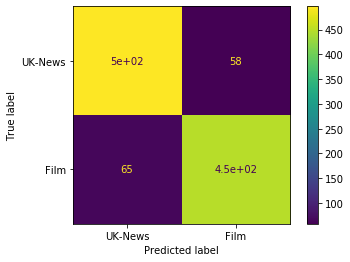

In [27]:
doc_train, doc_test, target_train, target_test = train_test_split(documents, target, test_size=0.3)

knc_pipeline.fit(doc_train, target_train)
print("Accuracy Score: %.4f" %knc_pipeline.score(doc_test,target_test))

predicted = knc_pipeline.predict(doc_test)

#create and display confusion matrix
cm = confusion_matrix(target_test, predicted, labels=['UK-News','Film'])
cmd = ConfusionMatrixDisplay(cm, display_labels=target_categories)
cmd.plot()

In [28]:
# apply 10-fold cross-validation, measuring accuracy each time
acc_scores = cross_val_score(knc_pipeline, documents, target, cv=10, scoring="accuracy")
s_acc = pd.Series(acc_scores)
print("Mean accuracy: %.4f" % s_acc.mean())

Mean accuracy: 0.8845


### 3. US News vs Film 

The final combination of categories is "US News" and "Film". Again we will be using the established pipeline. The method is basically the same.

In [29]:
us_vs_film = df.drop(df[df['Category']=='UK-News'].index)
us_vs_film

,Document,Category
0,"war epics, airmen and young sopranos: essentia...",Film
1,the most exciting movies of 2020 – horror the ...,Film
2,in the line of duty review – race-against-time...,Film
3,we are from jazz review – zany russian musical...,Film
4,first transgender marvel superhero coming 'ver...,Film
...,...,...
5376,from sarah cooper to fiona hill: the ‘stars’ o...,US-News
5377,what happened when california tried to fix its...,US-News
5378,first thing: mcconnell thwarts hopes of higher...,US-News
5379,joe biden to have new secret service team amid...,US-News


In [30]:
target_categories = ["Film", "US-News"]
documents = us_vs_film["Document"]

target = us_vs_film["Category"]

print("Number of US News Articles: %s" %target.value_counts()['US-News'])
print("Number of Film Articles: %s" %target.value_counts()['Film'])

Number of US News Articles: 1815
Number of Film Articles: 1771


Accuracy Score: 0.8949814126394052


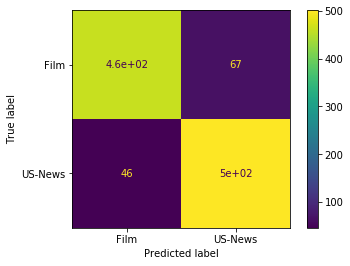

In [31]:
doc_train, doc_test, target_train, target_test = train_test_split(documents, target, test_size=0.3)

knc_pipeline.fit(doc_train, target_train)
print("Accuracy Score: %s" %knc_pipeline.score(doc_test,target_test))

predicted = knc_pipeline.predict(doc_test)

# calculate the matrix 
cm = confusion_matrix(target_test, predicted, labels=['Film','US-News'])
# display it graphically
cmd = ConfusionMatrixDisplay(cm, display_labels=target_categories)
cmd.plot()

In [32]:
acc_scores = cross_val_score(knc_pipeline, documents, target, cv=10, scoring="accuracy")
s_acc = pd.Series(acc_scores)
print("Mean accuracy: %.4f" % s_acc.mean())

Mean accuracy: 0.8926


# Multiclass Classification

The final part of the assignment is to perform multiclass classification on the data to see if we can load all of the articles in at once and perform classification on the three categories

We do our regular checks on how many articles are in each category and set up the lists $\texttt{document}$ and $\texttt{target}$ which will be used for classification 

In [33]:
all_categories=df

# 1 = Film, 2 = US News
target_categories = ["UK-News","Film", "US-News"]
# Content for all documents
documents = all_categories["Document"]
# Class labels for all documents
target = all_categories["Category"]


print("Number of UK News Articles: %s" %target.value_counts()['UK-News'])
print("Number of Film Articles: %s" %target.value_counts()['Film'])
print("Number of Us News Articles: %s" %target.value_counts()['US-News'])

Number of UK News Articles: 1795
Number of Film Articles: 1771
Number of Us News Articles: 1815


Accuracy Score: 0.8123839009287925


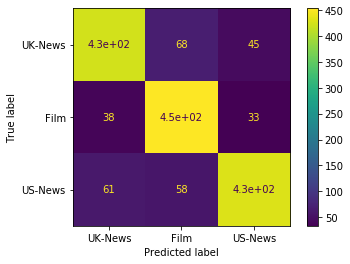

In [34]:
doc_train, doc_test, target_train, target_test = train_test_split(documents, target, test_size=0.3)

knc_pipeline.fit(doc_train, target_train)
print("Accuracy Score: %s" %knc_pipeline.score(doc_test,target_test))

predicted = knc_pipeline.predict(doc_test)

# calculate the matrix 
cm = confusion_matrix(target_test, predicted, labels=['UK-News','Film','US-News'])
# display it graphically
cmd = ConfusionMatrixDisplay(cm, display_labels=target_categories) 
cmd.plot()

The confusion matrix is shown above. We have the correct predictions clearly visible on the diagonal with the correctly classified values outnumbering the incorrect classification by an order of magnitude. 

This is promising but we still want to see exactly how the model perfoms. We turn to the classification report. 


In [35]:
print(classification_report(target_test, predicted, target_names=target_categories))

              precision    recall  f1-score   support

     UK-News       0.78      0.86      0.82       525
        Film       0.81      0.79      0.80       539
     US-News       0.85      0.78      0.81       551

    accuracy                           0.81      1615
   macro avg       0.81      0.81      0.81      1615
weighted avg       0.81      0.81      0.81      1615



To see how the test size affects the results of the classification we will test how the model performs over a range of test sizes from 90% of the total sample to 10%. The expectation here is that the runs that 

Accuracy Score: 0.6886
Accuracy Score: 0.6474
Accuracy Score: 0.7996
Accuracy Score: 0.8068
Accuracy Score: 0.8071
Accuracy Score: 0.8268
Accuracy Score: 0.8204
Accuracy Score: 0.8217
Accuracy Score: 0.8071


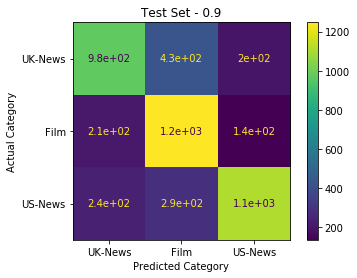

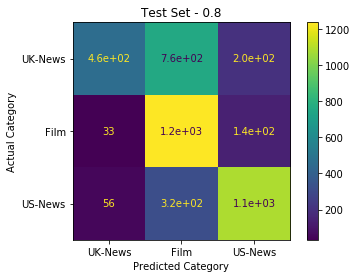

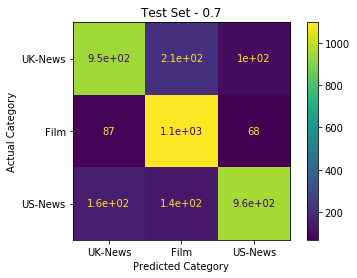

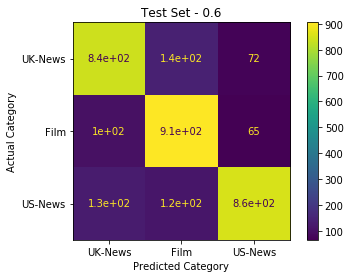

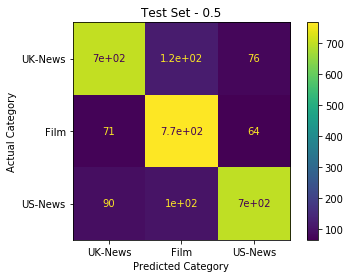

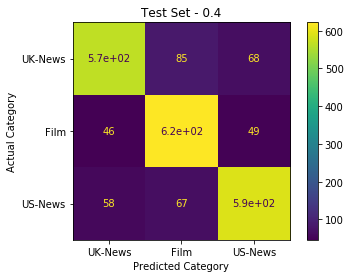

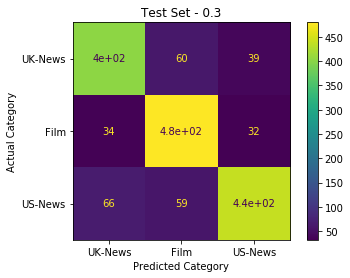

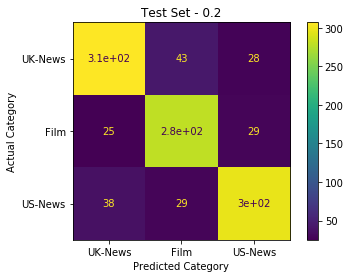

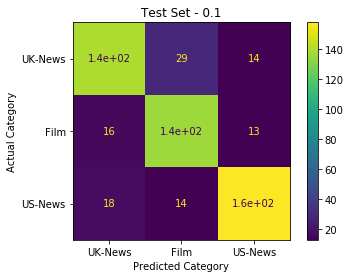

In [36]:
#from 90% to 10%
test_sizes = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]


for i in test_sizes:
    doc_train, doc_test, target_train, target_test = train_test_split(documents, target, test_size=i)    
    knc_pipeline.fit(doc_train, target_train)
    print("Accuracy Score: %.4f" %knc_pipeline.score(doc_test,target_test))    
    predicted = knc_pipeline.predict(doc_test)    
    cm = confusion_matrix(target_test, predicted, labels=['UK-News','Film','US-News'])
    cmd = ConfusionMatrixDisplay(cm, display_labels=target_categories) 
    cmd.plot()
    cmd.ax_.set(
                title='Test Set - %s' %i , 
                xlabel='Predicted Category', 
                ylabel='Actual Category')

The above matrices do make sense in the context of the procedure. We see in the first matrix that the test size is very big (as indicated by the scale on the colourbar) but thanks to the small training set the accuracy of the sample size is much less as signified by the size of the off-diagonal elements.

This follows intuition in that, as expected, given more training data the model will become more accurate.  

## Multiclass: Testing "Hard" and "Easy" examples

In this section just out of interest I want to see how the K-NN pipeline can handle custom news articles designed to be intentially confusing. For example will the model be able to classify an article such as "New film detailing Boris Johnson's handling of Brexit in production" as a film article and similar documents. 

These could be documents that have an overlap in category which is the case in many articles concerning UK-US relations. Or articles concerning events, celebrities or people of note where the category is initially unclear. 

In [37]:
easy_test=["Trump and Biden neck and neck in presidential race", #us news
           "Parliament meet to discuss increasing NHS budget", #uk news
           "Why superhero films are becoming the most popular genre"]  #film 

 
hard_test=["Joe Biden travels to UK to improve international relations post-Brexit", #US news
           "Kate Middleton under scrutiny from parenting groups", #UK news
           "New film detailing Boris Johnson's handling of Brexit in production"] #film

predicted_easy=knc_pipeline.predict(easy_test)
predicted_hard=knc_pipeline.predict(hard_test)

print(predicted_easy)
print(predicted_hard)

['US-News' 'UK-News' 'Film']
['US-News' 'UK-News' 'UK-News']


The model seems to be able to handle some of these muddier documents to a certain degree but it struggles if the vocabularly overlaps too much between categories.

There is no real quantitive result from this test but I was just interested to see how the model would perfom and to see if I could infer what was causing problems with the prediction model 

## Multiclass: K-Nearest Neighbour Vs. Other Methods
### 1. SGDC Method

Given that we have seen how the KNN classifier performed it may be interesting to compare it with other classifiers. First we'll use stochastic gradient descent text classification. This can be utilized using the $\texttt{SGDClassifier}$ function included in sklearn's library

In [38]:
#set up a pipeline
sgdc_pipeline = Pipeline([
    ('vec', TfidfVectorizer(stop_words="english",ngram_range=(1,2))),
    ('clf', SGDClassifier())
])

The rest of the process is basically the same as previous pipeline implementation.

Accuracy Score: 0.9473684210526315


[Text(0, 0.5, 'Actual Category'),
 Text(0.5, 0, 'Predicted Category'),
 Text(0.5, 1.0, 'Stochastic Gradient Descent')]

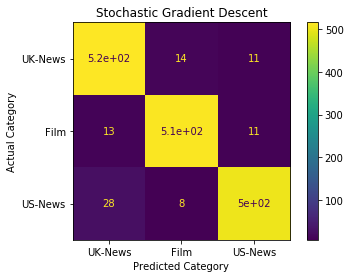

In [39]:
doc_train, doc_test, target_train, target_test = train_test_split(documents, target, test_size=0.3)

sgdc_pipeline.fit(doc_train, target_train)
print("Accuracy Score: %s" %sgdc_pipeline.score(doc_test,target_test))

predicted = sgdc_pipeline.predict(doc_test)

#confusion matrix
cm = confusion_matrix(target_test, predicted, labels=['UK-News','Film','US-News'])
cmd = ConfusionMatrixDisplay(cm, display_labels=target_categories) 
cmd.plot()
cmd.ax_.set(
            title='Stochastic Gradient Descent', 
            xlabel='Predicted Category', 
            ylabel='Actual Category')

In [40]:
#check the classification report
print(classification_report(target_test, predicted, target_names=target_categories))

              precision    recall  f1-score   support

     UK-News       0.96      0.96      0.96       536
        Film       0.93      0.95      0.94       540
     US-News       0.96      0.93      0.95       539

    accuracy                           0.95      1615
   macro avg       0.95      0.95      0.95      1615
weighted avg       0.95      0.95      0.95      1615



### 2. Naive Bayes Model 

A different method method we can try is the Naive-Bayes. According to sklearn this is a model that performs well given a small amount of training data and is known to be an effective classifier. 

In [41]:
#establish the pipeline
nmb_pipeline = Pipeline([
    ('vec', TfidfVectorizer(stop_words="english",ngram_range=(1,2))),
    ('clf', MultinomialNB())
])

Accuracy Score: 0.9417956656346749


[Text(0, 0.5, 'Actual Category'),
 Text(0.5, 0, 'Predicted Category'),
 Text(0.5, 1.0, 'Naive-Bayes')]

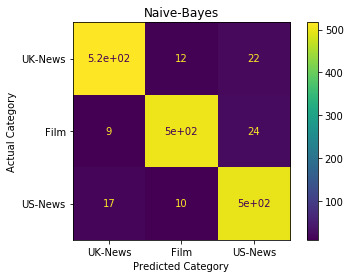

In [42]:
#run it again 
doc_train, doc_test, target_train, target_test = train_test_split(documents, target, test_size=0.3)

nmb_pipeline.fit(doc_train, target_train)
print("Accuracy Score: %s" %nmb_pipeline.score(doc_test,target_test))

predicted = nmb_pipeline.predict(doc_test)

# confusion matrix 
cm = confusion_matrix(target_test, predicted, labels=['UK-News','Film','US-News'])
cmd = ConfusionMatrixDisplay(cm, display_labels=target_categories) 
cmd.plot()
cmd.ax_.set(
            title='Naive-Bayes', 
            xlabel='Predicted Category', 
            ylabel='Actual Category')

## A brief comparison between models

To perform a crude comparison between the models we can set up a single set of training and test data and evaluate each model based on this unique set of test data. 

K-Nearest Neighbour accuracy Score: 0.8204
SDG accuracy Score: 0.9486
Naive-Bayes accuracy Score: 0.9307


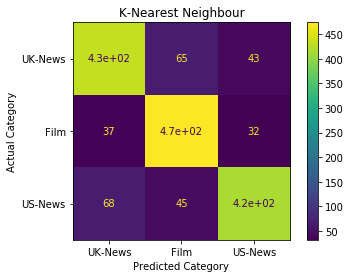

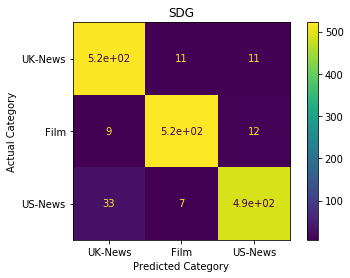

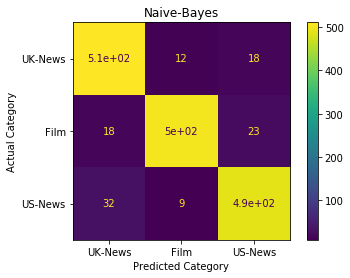

In [43]:
#define a dictionary that contains the pipelines and can call each one when neededd
models_dict={
    
    'K-Nearest Neighbour':knc_pipeline,
    'SDG':sgdc_pipeline,
    'Naive-Bayes':nmb_pipeline
}

doc_train, doc_test, target_train, target_test = train_test_split(documents, target, test_size=0.3)
for i in models_dict.keys():
    models_dict[i].fit(doc_train, target_train)
    print("%s accuracy Score: %.4f" %(i, models_dict[i].score(doc_test,target_test)))

    predicted = models_dict[i].predict(doc_test)
    cm = confusion_matrix(target_test, predicted, labels=['UK-News','Film','US-News'])
    cmd = ConfusionMatrixDisplay(cm, display_labels=target_categories)

    
    cmd.plot()
    cmd.ax_.set(
                title=i, 
                xlabel='Predicted Category', 
                ylabel='Actual Category')

# Conclusions

Using sklearn's functions text classification was performed on a large set of news articles taken from The Guardian's website. The aim was to classify the articles according to their respective news category (i.e. Sport, politics, film etc.).  

The first case dealt with binary classification and was tested on subsets of the overall data consisting of two categories. Term frequency–inverse document frequency was used as a weighting factor during vectorization process. The document term matrix for the news documents made use of unigrams and bigrams to improve identification of key terms. 

To improve efficiency of the code sklearn's $\texttt{pipeline}$ function was used which condenses the vectorization process and setting up of a model into a single function. 

The K-Nearest Neighbour model is used for the binary classification. For the 3 chosen categories and given a training-test ratio of 70-30  it was found to have a consistent prediction accuracy of $\sim85-90\%$. Similar values were found for the precision and f1 scores indicating a reasonable prediction model. This was further demonstrated with confusion matrices highlighing the regions of performance in the prediction model. 

The small variations due the random allocation of training/test data can be combatted using a k-fold technique. 

The next step was to implement multiclass classification that could ideally take any news articles and predict their categories. 
It was found that the pipeline used for the binary classification could be easily modified to handle multiclass classification, showing similar accuracy and precision scores. 

A brief investigation was made into the effect bigger or smaller training sets has on the predictive power of the models. As expected, the larger the training set the more accurately the model could classify the articles by category. 

The KNN multiclass classification model was established in quite a straightforward manner so to check its performance it was compared against a

Finally the K-NN classifer was compared to two other classification models: The Stochastic Gradient Descent model and the Naive Bayes Multinominal model. It was seen that the SGD classifier was the most accurate with a score of $\sim95\%$